In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Changing directory to Session 9 project folder
% cd /content/gdrive/My Drive/TSAI-EVA-7.0/09_ResNets_Higher_RF/

In [3]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.4 MB/s 
     |████████████████████████████████| 948 kB 38.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=47e459c1fb52fae999cac903de55c30a7588632690b3a80809c59890fbc303c8
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
! pip install grad-cam

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.5-py3-none-any.whl size=22419 sha256=9f3962ccc5a470089ca7944a5d79e58cd6ef5a955cb1655df93501a7e6df1e2a
  Stored in directory: /root/.cache/pip/wheels/89/d1/a6/41cb46183c56fe9e78ba80781ca35c3bc2728406b694fb7a13
Successfully built grad-cam


In [5]:
import torch.optim as optim
import torch.nn as nn

# PyTorch_Vision 
Accessing the repository with modular main.py, utils.py and model files.

In [6]:
! git clone https://github.com/lavanyanemani96/PyTorch_Vision
% cd PyTorch_Vision/

Cloning into 'PyTorch_Vision'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 143 (delta 71), reused 116 (delta 44), pack-reused 0
Receiving objects: 100% (143/143), 20.28 KiB | 716.00 KiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/gdrive/My Drive/EVA7/Session9/PyTorch_Vision


# Data

In [7]:
from main import * 

In [8]:
from utils import * 

In [9]:
Cifar10_train = dataset(A.Compose([ToTensorV2()]), True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [10]:
mu, sigma = mean_std_cifar10(Cifar10_train)

In [11]:
UnNorm = UnNormalize(mu, sigma) 

In [12]:
imgs = [item[0] for item in Cifar10_train] 
labels = [item[1] for item in Cifar10_train]

imgs = torch.stack(imgs, dim=0).numpy()

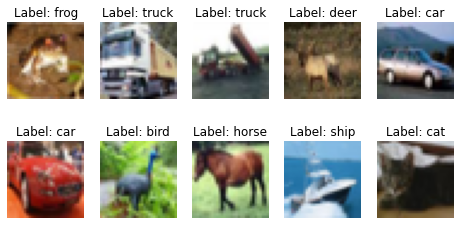

In [13]:
plot_grid(imgs, labels)

## Train/Test 

In [14]:
transforms_train = augmentation_custom_resnet('Train', mu, sigma)
transforms_test = augmentation_custom_resnet('Test', mu, sigma)

train_set = dataset(transforms_train, True)
test_set = dataset(transforms_test, False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
device, use_cuda = device()
batch_size = 512

In [16]:
train_loader = data_loader(train_set, args(batch_size, device, use_cuda)) 
test_loader = data_loader(test_set, args(batch_size, device, use_cuda))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# ResNet

In [17]:
from models.custom_resnet import Custom_ResNet

In [18]:
model = Custom_ResNet().to(device)

In [19]:
show_summary(model, device=device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

# OneCycle LR 

We will visually find max_lr for OneCycle LR scheduler

In [20]:
!pip install torch-lr-finder

In [21]:
from lr_finder import *

In [22]:
model = Custom_ResNet().to(device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-04


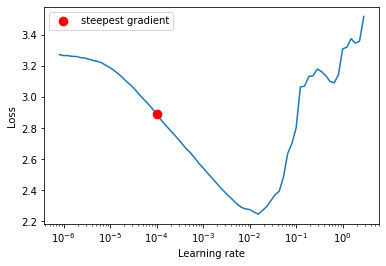

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
learning_rate_finder(criterion, optimizer, model, device, train_loader)

Visually, the max LR where loss is the lowest is ~1.5e-2

In [32]:
max_lr = 1.5e-2
min_lr = 1.00E-04

# Training

In [33]:
model = Custom_ResNet().to(device)

In [34]:
EPOCHS = 24
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=min_lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=EPOCHS, \
                                          steps_per_epoch=len(train_loader), pct_start = 5/24, \
                                          div_factor = 10, final_div_factor = 1, three_phase=False)

In [35]:
results = train_model_OCL(model, device, train_args(criterion, optimizer, scheduler), \
                      train_loader, test_loader, EPOCHS)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.5522428750991821 Batch_id=97 Accuracy=33.31: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]



Test set: Average loss: 0.0029, Accuracy: 4695/10000 (46.95%)

EPOCH: 1


Loss=1.0963900089263916 Batch_id=97 Accuracy=52.02: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.0022, Accuracy: 6026/10000 (60.26%)

EPOCH: 2


Loss=1.091962456703186 Batch_id=97 Accuracy=61.62: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]



Test set: Average loss: 0.0031, Accuracy: 5538/10000 (55.38%)

EPOCH: 3


Loss=0.954168438911438 Batch_id=97 Accuracy=66.94: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0018, Accuracy: 7003/10000 (70.03%)

EPOCH: 4


Loss=0.8199284672737122 Batch_id=97 Accuracy=72.74: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0014, Accuracy: 7664/10000 (76.64%)

EPOCH: 5


Loss=0.758563756942749 Batch_id=97 Accuracy=76.90: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0012, Accuracy: 7969/10000 (79.69%)

EPOCH: 6


Loss=0.5657686591148376 Batch_id=97 Accuracy=79.41: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0010, Accuracy: 8287/10000 (82.87%)

EPOCH: 7


Loss=0.4211899936199188 Batch_id=97 Accuracy=82.08: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0012, Accuracy: 8118/10000 (81.18%)

EPOCH: 8


Loss=0.460421621799469 Batch_id=97 Accuracy=83.17: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]



Test set: Average loss: 0.0008, Accuracy: 8653/10000 (86.53%)

EPOCH: 9


Loss=0.5649333000183105 Batch_id=97 Accuracy=84.72: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0010, Accuracy: 8479/10000 (84.79%)

EPOCH: 10


Loss=0.38035979866981506 Batch_id=97 Accuracy=85.93: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0009, Accuracy: 8585/10000 (85.85%)

EPOCH: 11


Loss=0.36352598667144775 Batch_id=97 Accuracy=87.26: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0007, Accuracy: 8823/10000 (88.23%)

EPOCH: 12


Loss=0.26512643694877625 Batch_id=97 Accuracy=88.37: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0007, Accuracy: 8877/10000 (88.77%)

EPOCH: 13


Loss=0.2624785006046295 Batch_id=97 Accuracy=89.71: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.0007, Accuracy: 8885/10000 (88.85%)

EPOCH: 14


Loss=0.2655078172683716 Batch_id=97 Accuracy=89.95: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0006, Accuracy: 9018/10000 (90.18%)

EPOCH: 15


Loss=0.22203436493873596 Batch_id=97 Accuracy=91.08: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0007, Accuracy: 8963/10000 (89.63%)

EPOCH: 16


Loss=0.2795713245868683 Batch_id=97 Accuracy=91.46: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0006, Accuracy: 9049/10000 (90.49%)

EPOCH: 17


Loss=0.20273610949516296 Batch_id=97 Accuracy=92.54: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0006, Accuracy: 9110/10000 (91.10%)

EPOCH: 18


Loss=0.23089465498924255 Batch_id=97 Accuracy=93.24: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0006, Accuracy: 9161/10000 (91.61%)

EPOCH: 19


Loss=0.14521440863609314 Batch_id=97 Accuracy=94.02: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0005, Accuracy: 9201/10000 (92.01%)

EPOCH: 20


Loss=0.12631525099277496 Batch_id=97 Accuracy=94.58: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.0005, Accuracy: 9183/10000 (91.83%)

EPOCH: 21


Loss=0.14535072445869446 Batch_id=97 Accuracy=95.11: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0005, Accuracy: 9194/10000 (91.94%)

EPOCH: 22


Loss=0.10249833762645721 Batch_id=97 Accuracy=95.27: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0005, Accuracy: 9216/10000 (92.16%)

EPOCH: 23


Loss=0.1256769895553589 Batch_id=97 Accuracy=95.64: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s]



Test set: Average loss: 0.0005, Accuracy: 9239/10000 (92.39%)



In [36]:
% cd ../
! ls 

/content/gdrive/My Drive/EVA7/Session9
plots  PyTorch_Vision  saved_models  Session_9_Resnets_Higher_RF.ipynb


In [37]:
import pandas as pd

In [38]:
df = pd.DataFrame(results)
df.to_csv('results.csv', index=False, header=False)

In [39]:
torch.save(model.state_dict(), './saved_models/model_weights.pth')

# Loss/Accuracy Curves

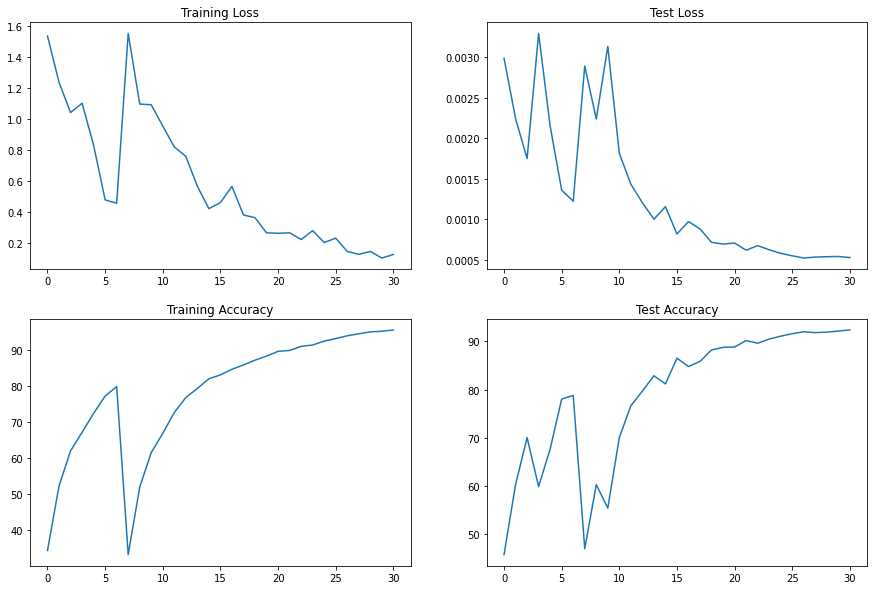

<Figure size 432x288 with 0 Axes>

In [40]:
plot_loss_accuracy(results)
plt.savefig('./plots/loss_accuracy.png')

# Predictions

In [41]:
n_images = 200

test_images = [item[0] for item in test_loader.dataset] 
test_images = torch.stack(test_images[:n_images])
test_targets = torch.tensor(test_loader.dataset.targets[:n_images]).to(device)
test_predictions = model(test_images.to(device))

In [42]:
correct = classfication_result(test_predictions, test_targets, device, b=True)
wrong = classfication_result(test_predictions, test_targets, device, b=False)

## Correct Classifications

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


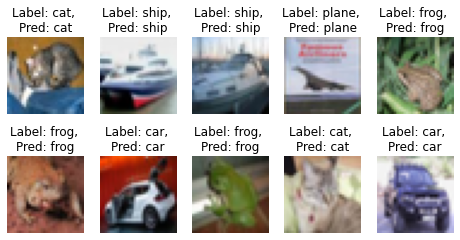

In [43]:
plot_grid(test_images[correct], test_targets[correct], UnNorm, test_predictions[correct])
plt.savefig('./plots/correct_classified.png')

## Wrong Classifications

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


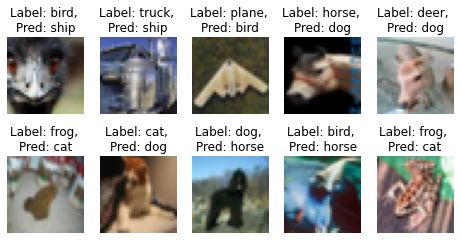

In [44]:
plot_grid(test_images[wrong], test_targets[wrong], UnNorm, test_predictions[wrong])
plt.savefig('./plots/misclassified.png')

# GradCam


In [45]:
cam = torch.from_numpy(grad_cam_OCL(model, use_cuda, test_images, test_targets))

## Correct Classifications GradCam 

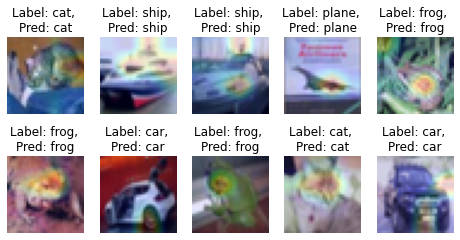

In [46]:
plot_grid_cam(test_images[correct], cam[correct], test_targets[correct], test_predictions[correct], UnNorm)
plt.savefig('./plots/correct_classified_gradcam.png')

## Wrong Classifications GradCam 

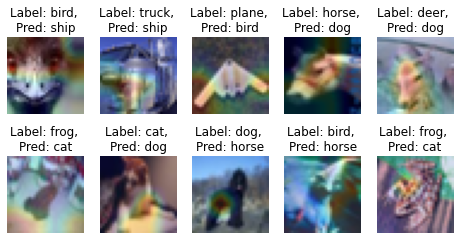

In [47]:
plot_grid_cam(test_images[wrong], cam[wrong], test_targets[wrong], test_predictions[wrong], UnNorm)
plt.savefig('./plots/misclassified_gradcam.png')